In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import HTML, IFrame, Image, SVG, Latex
import ROOT
from ROOT import RooFit, RooStats
%matplotlib inline
from ipywidgets import interact, interactive, fixed

ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.NumIntegration)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Fitting)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Minimization)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.InputArguments)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Eval)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.DataHandling)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)
ROOT.RooMsgService.instance().setSilentMode(True)

C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/home/turra/micromamba/envs/mamba-python3.11/bin/../lib/gcc/x86_64-conda-linux-gnu/12.4.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~
input_line_35:1:10: fatal error: 'dlfcn.h' file not found
#include "dlfcn.h"
         ^~~~~~~~~


In [2]:
from matplotlib import rcParams
rcParams.update({'font.size': 18})
HTML('<link rel="stylesheet" href="custom.css" type="text/css">')

In [3]:
#from notebook.services.config import ConfigManager
#cm = ConfigManager()
#cm.update('livereveal', {
#          'theme': 'sans',
#          'transition': 'zoom',
#})

In [4]:
def iter_collection(rooAbsCollection):
    iterator = rooAbsCollection.createIterator()
    object = iterator.Next()
    while object:
        yield object
        object = iterator.Next()

# new version, for newest ROOT
def iter_collection(rooAbsCollection):
    for object in rooAbsCollection:
        yield object

In [5]:
def RooDataSet2pandas(data):
    nevents = data.numEntries()
    columns = [x.GetName() for x in iter_collection(data.get(0))]
    return pd.DataFrame([[x.getVal() for x in iter_collection(data.get(ievent))] for ievent in xrange(nevents)], columns=columns)

In [6]:
def p2z(p_value, onetail=True):
    """ pvalue to significance """
    if not onetail:
        p_value /= 2
    return stats.norm.isf(p_value)  # inverse of the survival function

def z2p(z, onetail=True):
    """ significance to pvalue """
    if onetail:
        return stats.norm.sf(z)
    else:
        return stats.norm.sf(z) * 2

# Lecture 2

<p style="text-align: center;"><i class="icon-user icon-2x"><a href="mailto:ruggero.turra@mi.infn.it">ruggero.turra@mi.infn.it</a></i></p>
<br/>

## Content of the lecture

   * Hypothesis testing
   * Type or errors
   * Likelihood ratio
   * Neyman–Pearson lemma
   * Exclusions
   * Profiled likelihood ratio

## Simple and composite hypothesis

* A simple hypothesis is one in which all parameters of the distribution are specified

## Error type

   * Type I error: false positive (excessive credulity). Rate = $\alpha = P(\text{reject } H_0|H_0 \text{ is true})$
   * Type II error: false negative (excessive skepticism). Rate = $\beta = P(\text{don't reject } H_0|H_0 \text{ is false})$
   
   * Power of the test: $1-\beta$
   * Remember that "positive" / "negative" refers to $H_1$, the alternative hypothesis, e.g. positive means reject $H_0$
   * If $H_0$ is background only Type I is false discovery, Type II is missed discovery

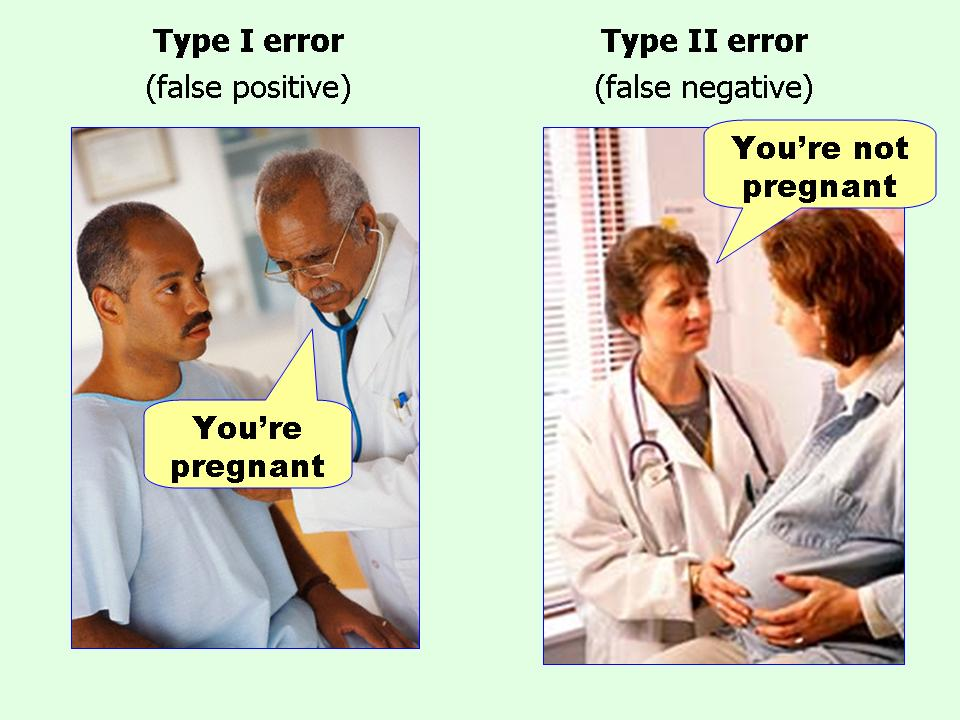

In [7]:
Image("img/type-i-and-type-ii-errors.jpg", width="70%")  # from https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg

### Question:
what is $H_0$ and $H_1$ in this sketch?

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
x = np.linspace(-5, 5, 200)
y0 = stats.norm.pdf(x, 0, 1)
y1 = stats.norm.pdf(x, 1, 1)
mask = x >= 2
ax.plot(x, y0, x, y1, '-')
ax.fill_between(x[mask], y0[mask], alpha=0.5)
ax.fill_between(x[~mask], y1[~mask], alpha=0.5)
ax.vlines(2, 0, 0.5, linestyle='--', lw=2)
#ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_xlabel("$q$")
ax.annotate("$f(q|H_1)$", xy=(x[100], y1[100]), xytext=(0.2, 0.7), textcoords="figure fraction", size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='C1')
ax.annotate("$f(q|H_0)$", xy=(x[90], y0[90]), xytext=(0.3, 0.8), textcoords="figure fraction", size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='C0')
ax.annotate(r"$\beta$", xy=(x[100], 0.1), xytext=(0.1, 0.5), textcoords="figure fraction", size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='red')
ax.annotate(r"$\alpha$", xy=(x[142], 0.01), xytext=(0.8, 0.25), textcoords="figure fraction", size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='blue')
ax.text(2, 0.4, r'$q_\alpha$', rotation='vertical', ha='right', size=20)
plt.close()

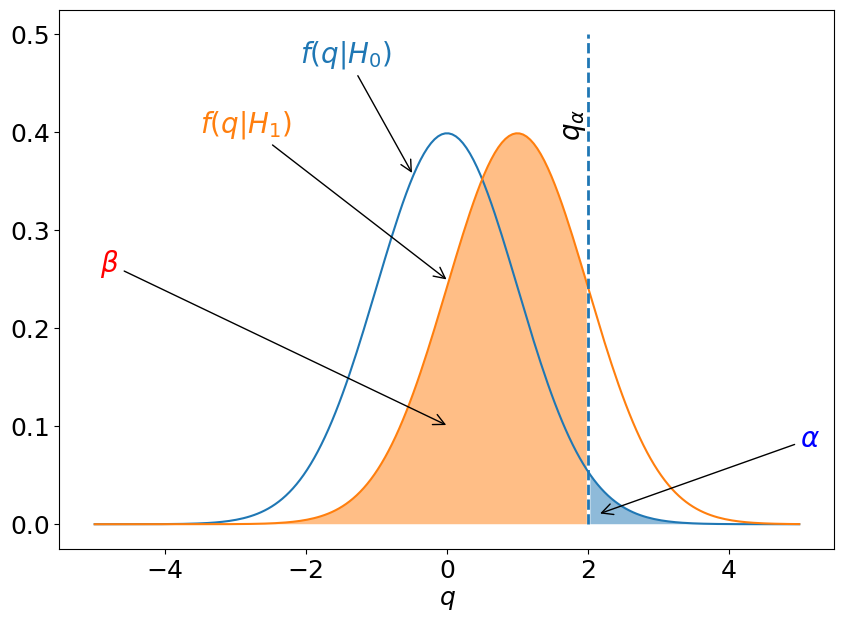

In [9]:
fig

Note that to evaluate $\beta = P(\text{don't reject } H_0|H_0 \text{ is false})$ we have used an alternative hypothesis $H_1$, but remember that if $H_0$ is false doesn't mean that $H_1$ is true.

The region $q > q_\alpha$ is the rejection region where we reject $H_0$. The complementary is the acceptance region.

## Hypothesis testing in practice

   * Define the null hypothesis you want to try to reject
   * Define the observables (number of events in the signal region, ...)
   * Fix the rate of type I error $\alpha$ of the test statistics (5%, $5\sigma$, ...)
   * Define the test statistic (trying to maximize the power $1-\beta$)
   * Find the rejection region ($q_{obs}>q_\alpha$), which is the region where $H_0$ is rejected (p-value $<\alpha$) (Reject $\Leftrightarrow q_{obs} > q_\alpha$)
   * Do the experiment
   * If the outcome is outside the acceptance region reject the null-hypothesis
   
In complex example one don't compute the acceptance region, but just compute the observed p-value

### Exercize: Lady tasting tea (Fisher "The Design of Experiments" - 1935)

A lady claimed to be able to tell whether the tea or the milk was added first to a cup. Fisher proposed to give her eight cups, four of each variety, in random order. What is the critical region at 5%? If we ask for a $5\sigma$ evidence, what's the minimum amount of cups we have to prepare? (Hint: look at the [Hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution), answer should be 26)

Are we interested in the rare case when the lady never guess? What is "more extreme" in this case?

### Example: Lady tasting tea 2.0

Suppose that the lady doesn't know how many cups of a kind are present. The acceptance region and the power (using p=90% as alternative hypothesis) can be computed easily from the binomial distribution.

To compute the rejection region we have to find the minimum $q_\alpha$ such that:

$$\sum_{n\geq q_{\alpha}} B(n|p=50\%, N=8) \leq \alpha$$

with $\alpha=5\%$. The solution can be found iteratively or inverting the formula (see the code). The lady has to guess correctly at least 7 cups. To compute the power simply using the definition

$$\text{power} = 1 - \beta = 1 - P(\text{don't reject $H_0$} | \text{$H_0$ is false}) = 1 - \sum_{n<7} B(n|p=90\%, N=8) = 81\%$$

Since $H_1$ is not a simple hypothesis (it doesn't tell us automatically how much is $p$) we have to assume one particular $H_1$ ($p=90\%$) to compute the power.

In [10]:
N = np.arange(1, 70)
alpha = np.sort(np.concatenate((np.logspace(-8, -3, 20), np.arange(0.001, 0.2, 0.002))))

kalpha = stats.binom.isf(alpha.reshape(len(alpha), 1), N, 0.5)
results_must_guess = kalpha.T + 1 
power = stats.binom.sf(kalpha, N, 0.9).T
min_N = np.ceil(np.log(alpha) / np.log(0.5))

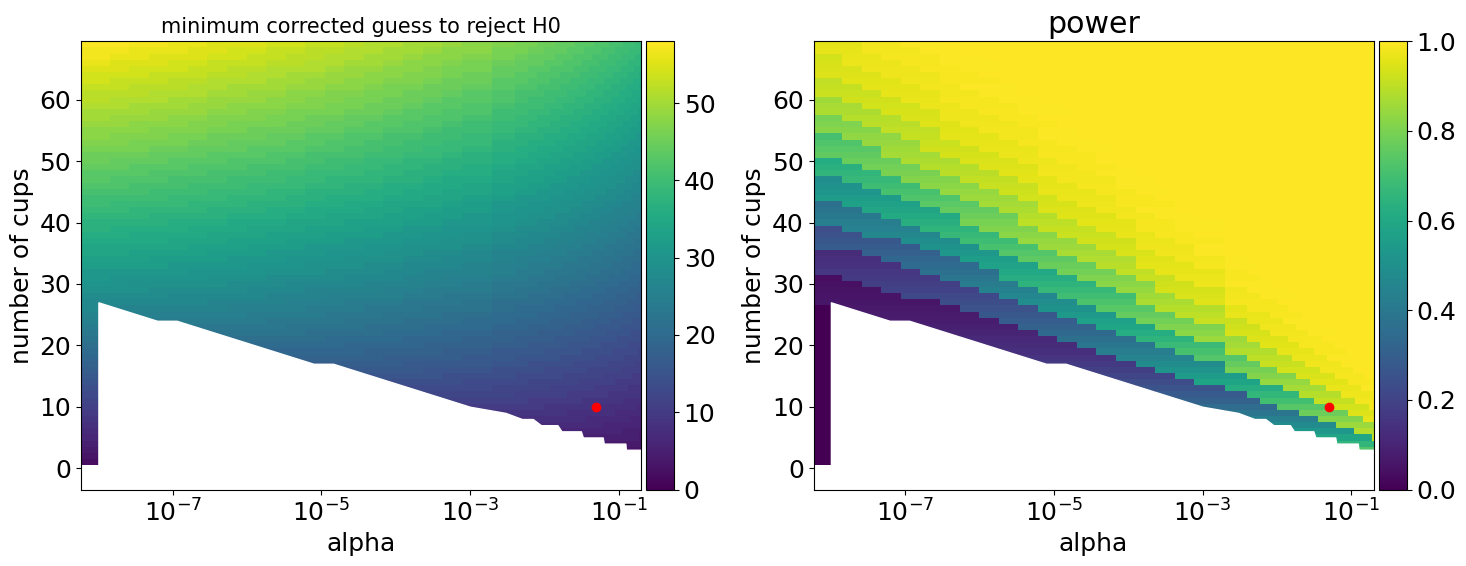

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 2, figsize=(15, 6))
p = ax[1].pcolormesh(alpha, N, power, vmin=0, vmax=1, cmap='viridis')
div = make_axes_locatable(ax[1])
cax = div.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(p, cax=cax)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
p = ax[0].pcolormesh(alpha, N, results_must_guess, vmin=0, cmap='viridis')
div = make_axes_locatable(ax[0])
cax = div.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(p, cax=cax)

ax[0].fill_between(alpha, min_N, color='white')
ax[1].fill_between(alpha, min_N, color='white')

ax[1].set_title('power')
ax[0].set_title('minimum corrected guess to reject H0', fontsize=15)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('number of cups')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of cups')

ax[0].plot(5E-2, 10, 'ro')
ax[1].plot(5E-2, 10, 'ro')

fig.tight_layout()
plt.show()

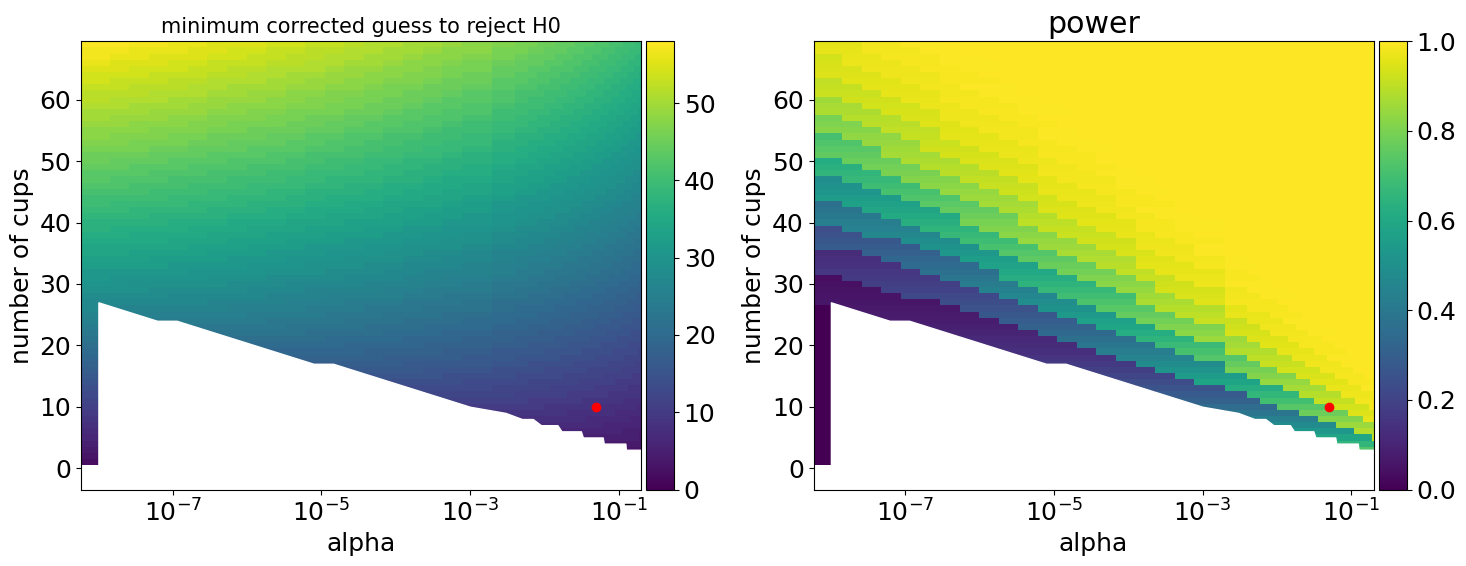

In [12]:
fig

## Neyman–Pearson lemma
Having two simple hypotheses (no additional parameters) $H_0: \theta = \theta_0$ and $H_1: \theta = \theta_1$, define the likelihood-ratio test:
$$
\Lambda(\vec x) = \frac{L(\theta_0|\vec x)}{L(\theta_1|\vec x)}
$$

which rejects $H_0$ in favour of $H_1$ when $\Lambda < q_\alpha$ (rejection region) with $\alpha=P(\Lambda(\vec x)\leq q_\alpha|H_0)$. The likelihood-ratio test ***is the most powerful test with size $\alpha$***.

### Example
Suppose you have a rock that seems to be opal (density 2.2 g/cm<sup>3</sup>), but may be also quartz (2.6 g/cm<sup>3</sup>). You have two instruments to measure the density, the first with resolution 0.2 g/cm<sup>3</sup>, the second with resolution 0.5 g/cm<sup>3</sup>. Opal is much expensive, we want to check if it is opal. $H_0:$quartz. What is the rejection region at 5%? Assume gaussian errors.

In [13]:
ws = ROOT.RooWorkspace()
true_density = ws.factory("true_density[2, 3]")
ws.factory("Gaussian::pdf1(density1[0,50], true_density, resolution1[0.5])")
ws.factory("Gaussian::pdf2(density2[0,50], true_density, resolution2[0.2])")
pdf = ws.factory("PROD::pdf(pdf1, pdf2)")

pdf_opal = ws.factory("EDIT:pdf_opal(pdf, true_density=density_opal[2.2])")
pdf_quartz = ws.factory("EDIT:pdf_quartz(pdf, true_density=density_quartz[2.6])")

In [14]:
# do the experiment, use H1 to generate (opal)
data = pdf_opal.generate(ROOT.RooArgSet(ws.var('density1'),
                                        ws.var('density2')), 1)  # generate with 1 entry
data.get(0).Print("V")

  1) RooRealVar:: density1 = 2.69947
  2) RooRealVar:: density2 = 2.11305


In [15]:
opal_model = RooStats.ModelConfig("opal (H1)", ws)   
opal_model.SetPdf(pdf_opal)
opal_model.SetParametersOfInterest('density_opal')  # not useful
opal_model.SetObservables('density1,density2')  # no space
opal_model.SetSnapshot(ROOT.RooArgSet(ws.var('density_opal')))

quartz_model = opal_model.Clone("quartz (H0)")
quartz_model.SetParametersOfInterest('density_quartz')  # not useful
quartz_model.SetPdf(pdf_quartz)

In [16]:
# define the test-statistic: -log L(H0)/L(H1)

test = RooStats.SimpleLikelihoodRatioTestStat(pdf_quartz, pdf_opal)  # null, alt
test.EnableDetailedOutput(True)

hypoCalc = RooStats.FrequentistCalculator(data, opal_model, quartz_model)  # alt, null
hypoCalc.SetToys(20000, 1000)  # generate much more toys for bkg-only

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(test)  # our test statistics
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)

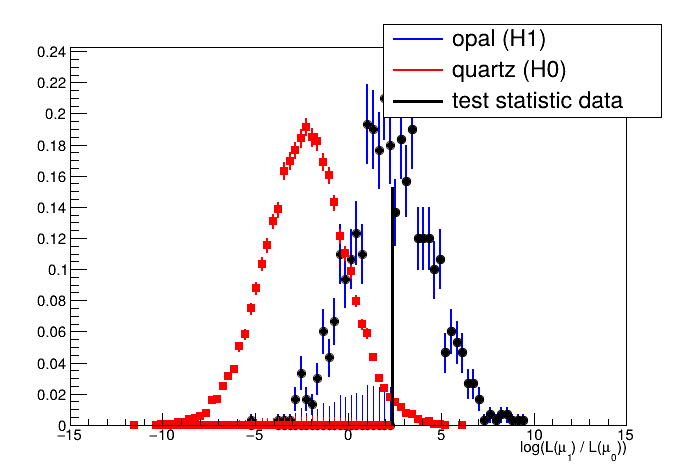

In [17]:
plot = RooStats.HypoTestPlot(htr, 100, -15, 15)
canvas = ROOT.TCanvas()
plot.Draw()
canvas.Draw()

In [18]:
print("observed qvalue: ", test.Evaluate(data, ROOT.RooArgSet(ws.var('density_quartz'))))
print("observed p-value: ", htr.NullPValue())
alpha = 0.05
kalpha = htr.GetNullDistribution().InverseCDF(1 - alpha)
beta = htr.GetAltDistribution().CDF(kalpha)
print(f"k_alpha = {kalpha}")
print(f"power = {1 - beta}")

observed qvalue:  2.3903879176554472
observed p-value:  0.015
k_alpha = 1.1855245352433041
power = 0.694


### Exercize
Show that the in this case the likelihood ratio is equivalent to the weighted mean of the two measurements

In [19]:
def eval_test_stat():
    d = ROOT.RooDataSet("d", "d", ROOT.RooArgSet(ws.var('density1'), ws.var('density2')))
    d.add(ROOT.RooArgSet(ws.var('density1'), ws.var('density2')))
    return test.Evaluate(d, ROOT.RooArgSet(ws.var('true_density')))

fig_opal, ax = plt.subplots(figsize=(12, 7))

x = np.linspace(1.3, 3.5, 100)
y = np.linspace(1.5, 3.5, 100)

qvalues = np.zeros((len(x), len(y)))
pdf_opal_values = np.zeros((len(x), len(y)))
pdf_quartz_values = np.zeros((len(x), len(y)))
for ix, xx in enumerate(x):
    for iy, yy in enumerate(y):        
        ws.var('density1').setVal(xx)
        ws.var('density2').setVal(yy)
        qvalues[iy, ix] = eval_test_stat()
        pdf_opal_values[iy, ix] = pdf_opal.getVal()
        pdf_quartz_values[iy, ix] = pdf_quartz.getVal()
        
c = plt.pcolormesh(x, y, qvalues, cmap='viridis')
cs = ax.contour(x, y, qvalues, [kalpha], linestyles='dashed')
ax.clabel(cs, fontsize=14, fmt=r"$k_\alpha$ = %1.3f", inline_spacing=30, use_clabeltext=True)
ax.contour(x, y, pdf_opal_values, cmap='Blues', alpha=0.6)
ax.contour(x, y, pdf_quartz_values, cmap='Oranges', alpha=0.6)
ax.plot(ws.var('density_opal').getVal(), ws.var('density_opal').getVal(), 'o', label='opal (H1)')
ax.plot(ws.var('density_quartz').getVal(), ws.var('density_quartz').getVal(), 'o', label='quartz (H0)')
ax.text(1.5, 1.6, "reject", size=20)
ax.text(1.8, 3.2, "accept", size=20)
datalist = [x.getVal() for x in iter_collection(data.get(0))]
ax.plot(datalist[0], datalist[1], 'v', label='observed', color='red')

ax.set_xlabel('density1')
ax.set_ylabel('density2')
ax.legend()
ax.set_aspect('equal')
plt.colorbar(c)
plt.close()

We can easily show the acceptance / rejection region in the space of the observables

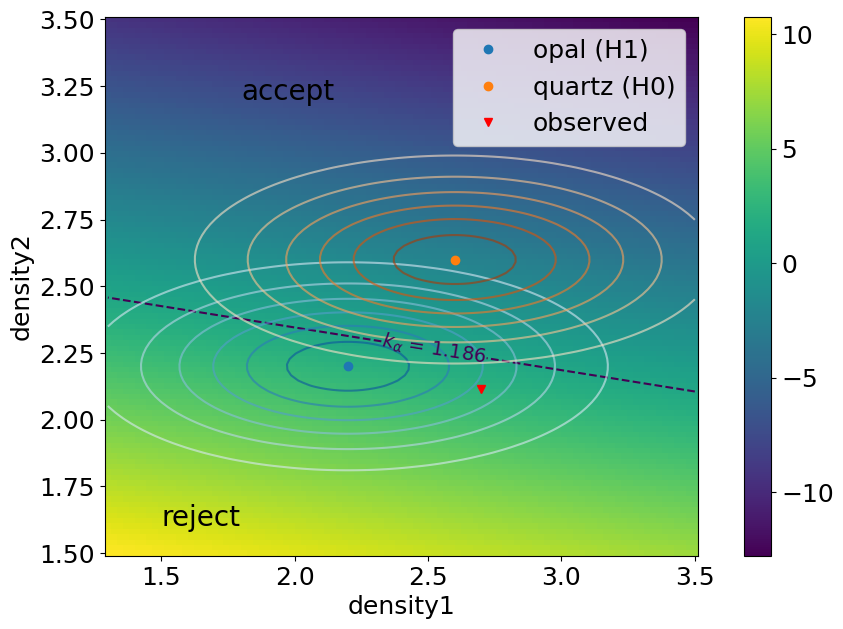

In [20]:
fig_opal

### Exercize
Compute the acceptance region using the simple mean as test-statistics: show that it is less powerful. What kind of shape is the acceptance region in this case?

### Plot the power as a function of the size of the test for the likelihood ratio

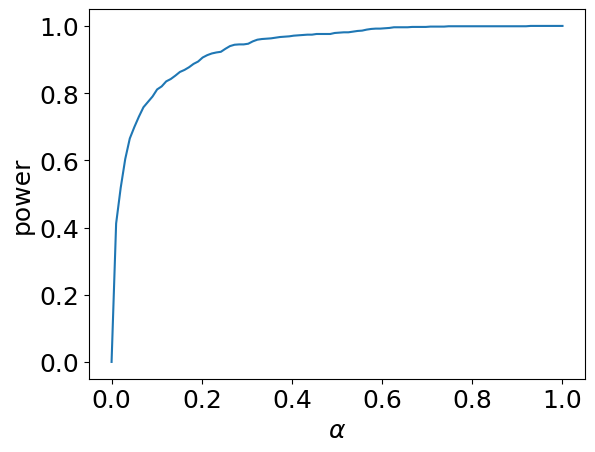

In [21]:
alphas = np.linspace(0, 1, 100)
powers = []

for alpha in alphas:
    kalpha = htr.GetNullDistribution().InverseCDF(1 - alpha)
    beta = htr.GetAltDistribution().CDF(kalpha)
    powers.append(1 - beta)
    
plt.plot(alphas, powers)   
plt.xlabel(r'$\alpha$')
plt.ylabel(r'power')
plt.show()

### Exercize
Compute $\text{power}(\alpha)$ for the simple mean and compare with the weighted mean.
### Exercize
Explain why the previous plot remembers the ROC curve (bkg-rejection vs signal-efficiency).

## Exclusion and frequentist intervals

By now we have done statistical test to discover something (a signal), defining the null hypothesis to be the background only case. Suppose we have counted $n_{obs}$ events in a Poissonian process with mean $\lambda$. What are the values $[\lambda_{up}, \infty]$ that we can exclude? This is something called hypothesis inversion. As usual we define the null hypothesis: $H_0: \lambda = N$ with $N > n_{obs}$. The likelihood:

$$L = \text{Pois}(n|N)$$

than the p-value of our observation $n_{obs}$:

$$\text{p-value} = \sum_{n\geq n_{obs}} \text{Pois}(n|N)$$

if p-value $<\alpha$ we consider $N$ to be inside the exluded region $[\lambda_{up}, \infty]$. The general approach is to scan for many value of $N$ until we found the one with p-value $=\alpha$, which is $n_{up}$.

### Example: RooFit asymmetric error bars

Let's do a two-side test and compute the excluded intervals $[-\infty, \lambda_{down}]$ and $[\lambda_{up}, \infty]$ with $\alpha=1 - 0.6827$. This means that every single interval should be tested with $\alpha=(1-0.6827)/2.=0.15865$. We can solve it analytically or with a scan. Suppose $n_{obs} = 4$.

In [22]:
NOBS = 4
ALPHA = z2p(1)  # 0.158...

def compute_pvalue(nobs, ntrue, left):
    if left:
        return stats.poisson(ntrue).cdf(nobs)
    else:
        return stats.poisson(ntrue).sf(nobs) + stats.poisson(ntrue).pmf(nobs)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))
x = np.linspace(NOBS, NOBS + 3 * NOBS, 20)

axs[1].plot(x, compute_pvalue(NOBS, x, left=True), 'r')
axs[1].hlines(ALPHA, np.min(x), np.max(x), linestyles='--')

x = np.linspace(max(NOBS - NOBS * 3, 0), NOBS, 100)
axs[0].plot(x, compute_pvalue(NOBS, x, left=False), 'b')
axs[0].hlines(ALPHA, np.min(x), np.max(x), linestyles='--')

from scipy.optimize import brenth
lambda_up = brenth(lambda x: compute_pvalue(NOBS, x, True) - ALPHA, NOBS, NOBS * 3)
lambda_down = brenth(lambda x: compute_pvalue(NOBS, x, False) - ALPHA, 1E-5, NOBS)

axs[1].plot(lambda_up, compute_pvalue(NOBS, lambda_up, True), 'ro')
axs[0].plot(lambda_down, compute_pvalue(NOBS, lambda_down, False), 'bo')
axs[1].set_xlabel('$\lambda$'); axs[0].set_xlabel('$\lambda$')
axs[1].set_ylabel('$P(n\leq n_{obs})$')
axs[0].set_ylabel('$P(n\geq n_{obs})$')
plt.close()

In [23]:
x = np.arange(0, NOBS * 3)
axs[2].step(x, stats.poisson(lambda_up).pmf(x), 'r', label='Pois[$\lambda=\lambda_{up}$]')
axs[2].step(x, stats.poisson(lambda_down).pmf(x), 'b', label='Pois[$\lambda=\lambda_{down}$]')
axs[2].vlines(NOBS, 0, 0.3, linestyles='--')
axs[2].legend(fontsize=12, loc=0)
axs[2].set_xlabel('n')
fig.tight_layout()

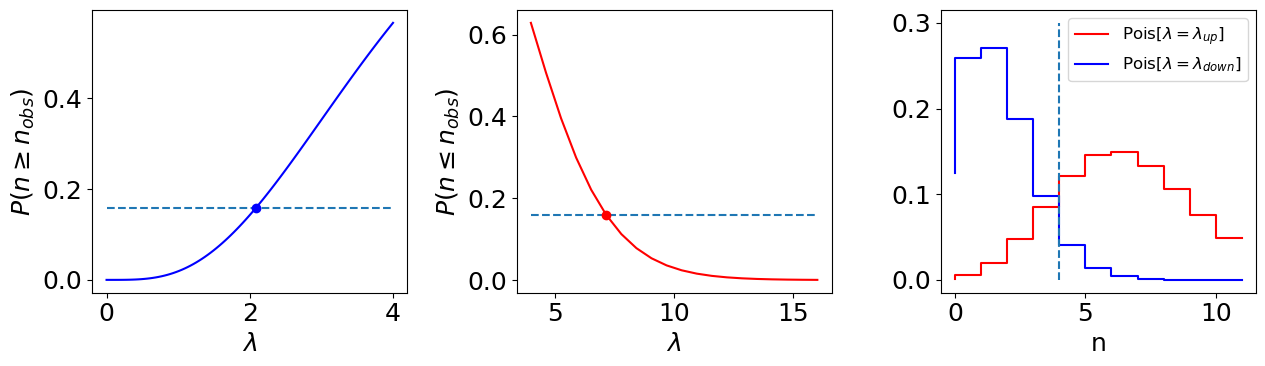

In [24]:
fig

In [25]:
print(lambda_down, lambda_up)
Latex("$\lambda = %.2f^{+%.2f}_{-%.2f}$" % (NOBS, lambda_up - NOBS, NOBS - lambda_down))

2.0856608137771175 7.1627531722609445


<IPython.core.display.Latex object>

### Question:
why we assumed that the central value for $\lambda$ is $n_{obs}=4$?

In [26]:
def get_confiderence_poisson(n):
    ym = np.array([0], dtype=np.float64)
    yp = np.array([0], dtype=np.float64)
    ROOT.RooHistError.instance().getPoissonInterval(n, ym, yp, 1)
    return ym[0], yp[0]

get_confiderence_poisson(4)

(2.085660813777117, 7.162753172260944)

This is the function used by RooFit to draw error bands

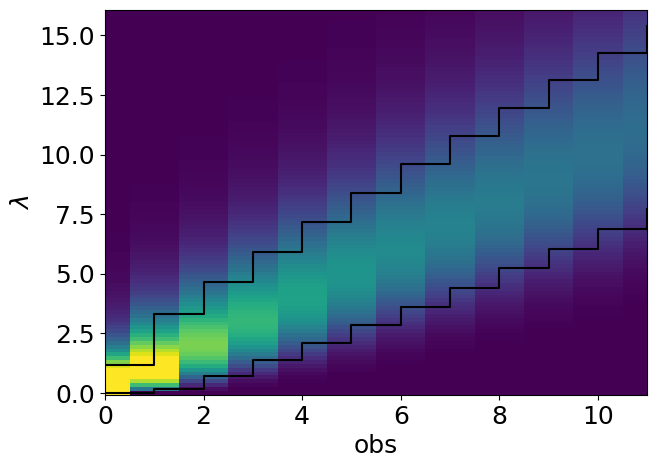

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
trues = np.linspace(1E-5, NOBS * 4, 100)
obss = np.arange(0, NOBS * 3, dtype=np.int32)
v = np.zeros((len(trues), len(obss)))
limits = []
for ix, obs in enumerate(obss):
    limits.append(get_confiderence_poisson(int(obs)))
    for iy, true in enumerate(trues):
        v[iy, ix] = stats.poisson(true).pmf(obs)
ax.pcolormesh(obss, trues, v, vmax=np.percentile(v, 99))
ax.plot(obss, np.array(limits).T[0], 'k', drawstyle='steps-post')
ax.plot(obss, np.array(limits).T[1], 'k', drawstyle='steps-post')
ax.set_xlim(0, np.max(obss))
ax.set_xlabel('obs')
ax.set_ylabel('$\lambda$'); plt.show()

### Question: explain why this is a frequentist procedure

## Bayesian approach

$$P(\lambda|n_{obs}) = P(n_{obs}|\lambda)P(\lambda)$$

We assume the prior $P(\lambda)$ to be flat (and zero for negative values), equivalent to a constant we can ignore. Everybody agree?

$$P(\lambda|n_{obs}) = P(n_{obs}|\lambda)$$

note that $n_{obs}$ is fixed, so this is a real function $f(\lambda)$. Let find a region [low, high] such that

$$\int_{low}^{high} P(\lambda|n_{obs}) = 68\%$$

In [28]:
def f(true):
    return stats.poisson(true).pmf(NOBS)

import scipy
from scipy.optimize import brenth, brentq
def f_low(x):
    return scipy.integrate.quad(f, 0, x)[0] - z2p(1)

def f_hi(x):
    return scipy.integrate.quad(f, x, NOBS * 10)[0] - z2p(1)

lo_bayes, hi_bayes = brentq(f_low, 1E-5, NOBS), brentq(f_hi, NOBS, NOBS * 5)
print(lo_bayes, hi_bayes)
Latex("$\lambda = %.2f_{-%.2f}^{+%.2f}$" % (NOBS, NOBS - lo_bayes, hi_bayes - NOBS))

2.8403088555932197 7.162753172255066


<IPython.core.display.Latex object>

In [29]:
def invert(f, y, a, b):
    return brentq(lambda x: f(x) - y, a, b)

lo_bayes_el = brenth(
    lambda x: scipy.integrate.quad(f, x, invert(f, f(x), x * (1 + 1E-5), NOBS * 20))[0] - (1 - z2p(1) * 2),
    1E-2, NOBS - 1E-2)
hi_bayes_el = invert(f, f(lo_bayes_el), NOBS, NOBS * 5)
print(lo_bayes_el, hi_bayes_el)

2.289882379081169 6.402859007849325


In [30]:
def width_interval(x):
    return brenth(lambda y: scipy.integrate.quad(f, x, y)[0] - (1 - z2p(1) * 2), x, NOBS * 20) - x

sol = scipy.optimize.minimize_scalar(width_interval, (1E-1, 3), bounds=(0, NOBS), method='bounded')
lo_bayes_min, hi_bayes_min = sol.x, sol.x + width_interval(sol.x)
print(lo_bayes_min, hi_bayes_min)

2.289882286599089 6.402858915367273


In [31]:
x = np.linspace(0, NOBS * 3, 100)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].plot(x, f(x))
axs[0].fill_between(np.linspace(0, lo_bayes, 50), f(np.linspace(0, lo_bayes, 50)))
axs[0].fill_between(np.linspace(hi_bayes, NOBS * 3, 50), f(np.linspace(hi_bayes, NOBS * 3, 50)))
axs[0].set_title('equal probability (central)', fontsize=15)
axs[0].text(7, 0.16, '$\lambda = %.2f_{-%.2f}^{+%.2f}$' % (NOBS, NOBS - lo_bayes, hi_bayes - NOBS), size=15)
axs[0].text(4, 0.04, '68%', size=15)
axs[0].set_xlabel('$\lambda$')
axs[1].plot(x, f(x))
axs[1].fill_between(np.linspace(0, lo_bayes_el, 50), f(np.linspace(0, lo_bayes_el, 50)))
axs[1].fill_between(np.linspace(hi_bayes_el, NOBS * 3, 50), f(np.linspace(hi_bayes_el, NOBS * 3, 50)))
axs[1].set_title('equal likelihood', fontsize=15)
axs[1].text(7, 0.16, '$\lambda = %.2f_{-%.2f}^{+%.2f}$' % (NOBS, NOBS - lo_bayes_el, hi_bayes_el - NOBS), size=15)
axs[1].text(3.5, 0.04, '68%', size=15)
axs[1].set_xlabel('$\lambda$')
axs[2].plot(x, f(x))
axs[2].fill_between(np.linspace(0, lo_bayes_min, 50), f(np.linspace(0, lo_bayes_min, 50)))
axs[2].fill_between(np.linspace(hi_bayes_min, NOBS * 3, 50), f(np.linspace(hi_bayes_min, NOBS * 3, 50)))
axs[2].set_title('minimum interval', fontsize=15)
axs[2].text(7, 0.16, '$\lambda = %.2f_{-%.2f}^{+%.2f}$' % (NOBS, NOBS - lo_bayes_min, hi_bayes_min - NOBS), size=15)
axs[2].text(3.5, 0.04, '68%', size=15)
axs[2].set_xlabel('$\lambda$')
for ax in axs: ax.set_yticklabels([])
plt.close()

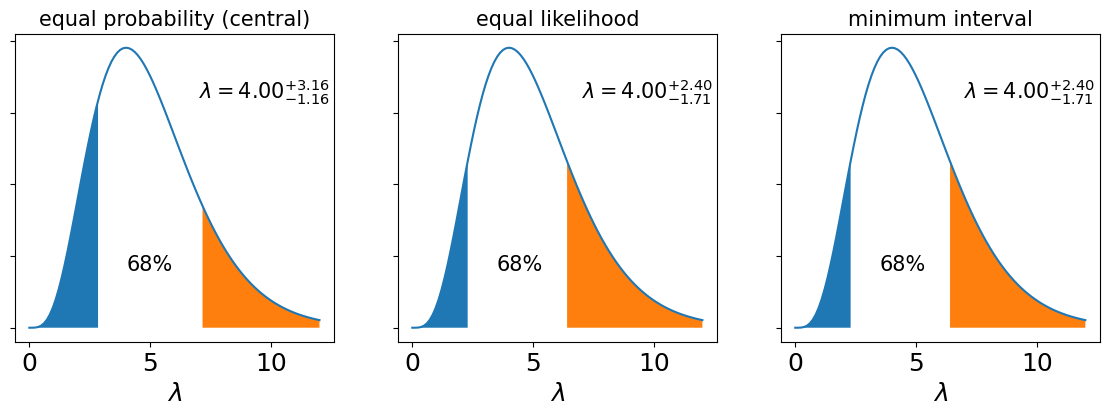

In [32]:
fig

## Profile likelihood ratio

Suppose you have composite hypothesis as 

$$H_0: \theta\in\Theta_0 \quad H_1: \theta\in\Theta_0^C \quad \Theta_0\subset\Theta$$

where $\Theta_0 = \{s=0, \ldots\}$, $\Theta_0^C = \{s\neq 0, \ldots\}$. $x$ are the data.

$$\lambda(x) = \frac{\sup_{\theta\in\Theta_0}{L(\theta|x)}}{\sup_{\theta\in\Theta}{L(\theta|x)}}$$

For example it can be $H_0: s=0$, $H_1: s\neq 0$

$$\lambda(x) = \frac{\sup_{\theta}L(s=0, \theta|x)}{\sup_{\theta,s} L(s, \theta|x)}=\frac{L(s=0, \hat{\hat\theta}(0)|x)}{L(\hat{s}, \hat\theta|x)}$$

<small>
where $\hat{\hat\theta}(0)$ is the value of $\theta$ which optimize the likelihood for $s=0$ (conditioned likelihood), while $\hat{s}$ and $\hat{\theta}$ are the values that optimize the likelihood without any constrains (unconditioned likelihood).
</small>

It varies between 0 and 1, low values mean that the observed result is less likely to occur under the null hypothesis as compared to the alternative. (numerator $\leq$ denominator)

The profile likelihood ratio is nearly an optimal test-statistics

As shown it is important to have an analytically expression $f_q$ of the distribution of the test-statistics $q$ to compute the p-value: $\text{p-value} = \int_{q^\text{obs}}^{\infty} f_q(q) dq$. Otherwise toys must be run.

## Wilks's theorem

The quantity $t=-2\log(\lambda)$ is aymptotically (large sample) distributed as a $\chi^2$ distribution with $n=\text{dim}(\Theta)-\text{dim}(\Theta_0)$ degrees of freedom when $H_0$ is true.

Let resurrect the simple Poisson model $\text{Poisson}(n|s + b)$. This time, instead of using the number of observed events as test-statistics, let use the profile likelihood ratio.

In [33]:
S, B = 30, 200  # expected values

ws_poisson = ROOT.RooWorkspace('ws_poisson')
b = ws_poisson.factory("b[%f]" % B)
n_exp = ws_poisson.factory("sum::n_exp(s[%f, -500, 500], b)" % S)
pdf = ws_poisson.factory("Poisson::pdf(n_obs[0, 1000], n_exp)")
aset = ROOT.RooArgSet(ws_poisson.var('n_obs'))
data = pdf.generate(aset, 1)  # generate with 1 entry
print("observed = ", data.get(0).first().getVal())

observed =  229.0


In [34]:
# create a MC linked to the ws
sbModel = RooStats.ModelConfig("sbmodel", ws_poisson)   
sbModel.SetPdf(pdf)
sbModel.SetObservables('n_obs')  # it understands variable-names
sbModel.SetParametersOfInterest('s')
# save the value of s for (s+b)-hypothesis
sbModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(sbModel)  # import is a keyword in python

bModel = sbModel.Clone("bmodel")  # create a bkg-only model
ws_poisson.var('s').setVal(0)             # with no signal
bModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(bModel);

In [35]:
profll = RooStats.ProfileLikelihoodTestStat(bModel.GetPdf())
# this modify a bit our test statistics
profll.SetOneSidedDiscovery(1)

hypoCalc = RooStats.FrequentistCalculator(data, sbModel, bModel)
hypoCalc.SetToys(100000, 5000)  # generate much more toys for bkg-only

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(profll)
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)

pvalue =  0.02451  significance =  1.9684176737724473


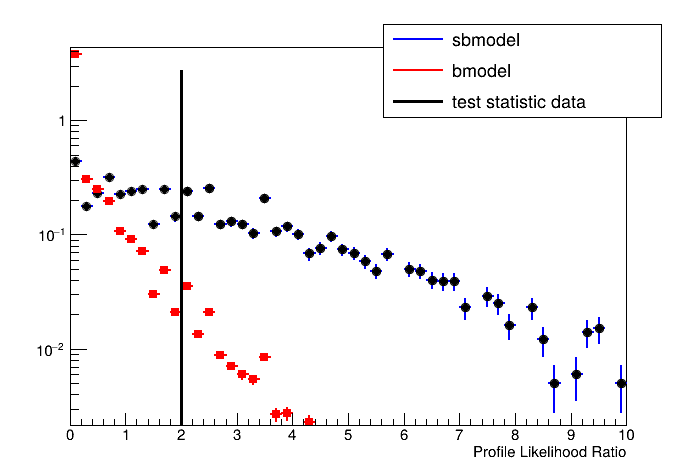

In [36]:
plot = RooStats.HypoTestPlot(htr, 50, 0, 10)
canvas = ROOT.TCanvas()
plot.Draw()
canvas.SetLogy(); canvas.Draw()
print("pvalue = ", htr.NullPValue(), " significance = ", htr.Significance())

The distribution under the $H_0$ has a peak at 0, which does not follow the $\chi^2$ distribution. Explain why (see test statistics for one-side-discovery and SetOneSideDiscovery(True) option).

We can also use the AsymtoticCalculator, which instead of using the empirical distribution of the likelihood ratio from toys, it uses the asymptotic distribution ($\chi^2_1$ distribution for the simple likelihood ratio)

In [37]:
hypoCalc = RooStats.AsymptoticCalculator(data, sbModel, bModel)
hypoCalc.SetOneSidedDiscovery(True)
htr_asym = hypoCalc.GetHypoTest()
print("pvalue =", htr_asym.NullPValue(), " significance =", htr_asym.Significance())

pvalue = 0.022544284300433422  significance = 2.003827251118166
AsymptoticCalculator::EvaluateNLL  ........ using  / Migrad with strategy  1 and tolerance 1
Minuit2Minimizer: Minimize with max-calls 500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 3.63616348402820222
Edm   = 4.8258587877775207e-08
Nfcn  = 18
s	  = 28.9953	 +/-  15.1301	(limited)
AsymptoticCalculator::EvaluateNLL -  value = 3.63616	fit time : Real time 0:00:00, CP time 0.000
MakeAsimov: Setting poi s to a constant value = 30
Generated Asimov data for observables RooArgSet:: = (n_obs)
AsymptoticCalculator::EvaluateNLL -  value = 3.63834 for poi fixed at = 30

AsymptoticCalculator::EvaluateNLL -  value = 5.64383 for poi fixed at = 0
AsymptoticCalculator::EvaluateNLL -  value = 5.78359 for poi fixed at = 0


## On/off problem

Let's introduce a classical problem in high-energy / astro / ... physics. Suppose you have a source that can contain signal and background events. You have an other source that contains only background events and the background in the two source is correlated.

This is the case when you have a control region, with only background, and a signal region with signal plus background. Usually the correlation of the background between the two region comes from a simulation. In astrophysics this can be the case when with telescope one wants to see if there is source in a particular region of the sky, using as control region the average of regions where there are no known source.



In term of random variables:

$$ N_{SR} = S + B \qquad N_{CR} = \alpha B$$

with $S$ and $B$ distributed as Poisson distribution. What we observe are the number of events in the signal region $n_{SR}$ and in the control region $n_{CR}$. $\alpha$ is assumed to be a known constant. We can write the likelihood as:

$$L(s, b|n_{SR}, n_{CR}) = \text{Pois}(n_{SR}|s + b) \text{Pois}(n_{CR}|\alpha b)$$

remember that $\alpha$ is a known constant. The test statistics is based on the profiled likelihood ratio:

$$-2\log\lambda = -2\log\frac{\sup_{b \in [0, \infty], s\in\{0\}}{L(s, b)}}{\sup_{b\in [0, \infty], s\in [0, \infty]}{L(s, b)}} = -2\log\frac{L(0, \hat{\hat{b}}(s=0))}{L(\hat{s}, \hat{b})}$$


In [38]:
ws_onoff = ROOT.RooWorkspace('ws_onoff')
model_sr = ws_onoff.factory("Poisson:N_SR(n_sr[0, 5000], sum:s_plus_b(s[15, 0, 100], b[50, 0, 100] ))")
model_cr = ws_onoff.factory("Poisson:N_CR(n_cr[0, 5000], prod:alpha_x_b(alpha[10, 0, 10], b))")
model = ws_onoff.factory("PROD:model(N_SR, N_CR)")
ws_onoff.var("alpha").setConstant(True)

sbModel = RooStats.ModelConfig('sbModel', ws_onoff)
sbModel.SetObservables('n_sr,n_cr')
sbModel.SetParametersOfInterest('s')
sbModel.SetPdf('model')
sbModel.SetSnapshot(ROOT.RooArgSet(ws_onoff.var('s')))
getattr(ws_onoff, 'import')(sbModel)

bModel = sbModel.Clone("bModel")
ws_onoff.var('s').setVal(0)
bModel.SetSnapshot(bModel.GetParametersOfInterest())

ws_onoff.Print()
ws_onoff.writeToFile('onoff.root')

False


RooWorkspace(ws_onoff) ws_onoff contents

variables
---------
(alpha,b,n_cr,n_sr,s)

p.d.f.s
-------
RooPoisson::N_CR[ x=n_cr mean=alpha_x_b ] = 0
RooPoisson::N_SR[ x=n_sr mean=s_plus_b ] = 0
RooProdPdf::model[ N_SR * N_CR ] = 0

functions
--------
RooProduct::alpha_x_b[ alpha * b ] = 500
RooAddition::s_plus_b[ s + b ] = 50

parameter snapshots
-------------------
sbModel__snapshot = (s=15)
bModel__snapshot = (s=0)

named sets
----------
bModel__snapshot:(s)
sbModel_Observables:(n_sr,n_cr)
sbModel_POI:(s)
sbModel__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::sbModel



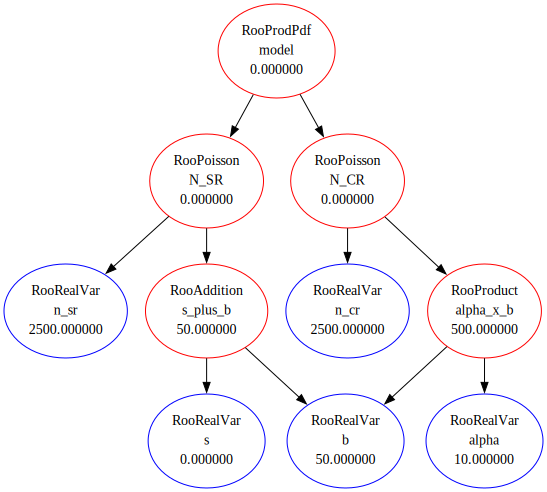

In [39]:
model.graphVizTree("on_off_graph.dot")
!dot -Tsvg on_off_graph.dot > on_off_graph.svg; rm on_off_graph.dot
SVG("on_off_graph.svg")

In [40]:
sbModel.LoadSnapshot()
data = model.generate(bModel.GetObservables(), 1)
print("observed  N_SR = %.f, N_CR = %.f" % tuple([x.getVal() for x in iter_collection(data.get(0))]))
model.fitTo(data)
print("\nbest fit     s        b")
print("SR    {:>8.1f} {:>8.1f}".format(ws_onoff.var('s').getVal(), ws_onoff.var('b').getVal()))
print("CR             {:>8.1f}".format(ws_onoff.function('alpha_x_b').getVal()))

observed  N_SR = 57, N_CR = 447

best fit     s        b
SR        12.3     44.7
CR                447.0


In [41]:
profll = RooStats.ProfileLikelihoodTestStat(bModel.GetPdf())
# this modify a bit our test statistics
profll.SetOneSidedDiscovery(True)

hypoCalc = RooStats.FrequentistCalculator(data, sbModel, bModel)
hypoCalc.SetToys(10000, 500)

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(profll)
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)

pvalue =  0.0443  significance =  1.702829395744341


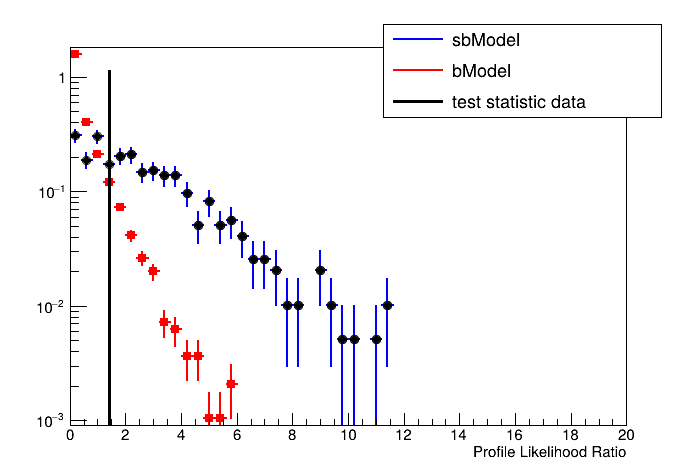

In [42]:
plot = RooStats.HypoTestPlot(htr, 50, 0, 20)
canvas = ROOT.TCanvas()
plot.Draw()
canvas.SetLogy()
canvas.Draw()
print("pvalue = ", htr.NullPValue(), " significance = ", htr.Significance())

In [43]:
hypoCalc = RooStats.AsymptoticCalculator(data, sbModel, bModel)
hypoCalc.SetOneSidedDiscovery(True)
htr = hypoCalc.GetHypoTest()
print("pvalue =", htr.NullPValue(), " significance =", htr.Significance())

pvalue_exp = RooStats.AsymptoticCalculator.GetExpectedPValues(htr.NullPValue(), htr.AlternatePValue(), 1, False, True)
significance_exp = ROOT.Math.normal_quantile_c(pvalue_exp, 1)
print("expected p-value = ", pvalue_exp, " significance =", significance_exp)

pvalue = 0.046960674305756095  significance = 1.6750656653467675
expected p-value =  0.15202103457917066  significance = 1.027803925955747
AsymptoticCalculator::EvaluateNLL  ........ using  / Migrad with strategy  1 and tolerance 1
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 6.91233052650801483
Edm   = 1.27558666860002018e-07
Nfcn  = 25
b	  = 44.6991	 +/-  2.11354	(limited)
s	  = 12.3028	 +/-  7.76596	(limited)
AsymptoticCalculator::EvaluateNLL -  value = 6.91233	fit time : Real time 0:00:00, CP time 0.000
MakeAsimov: Setting poi s to a constant value = 15
MakeAsimov: doing a conditional fit for finding best nuisance values 
Minuit2Minimizer: Minimize with max-calls 500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 6.97007284951206429
Edm   = 5.23661835873340247e-08
Nfcn  = 13
b	  = 44.5114	 +/-  2.03345	(limited)
fit time Real time 0:00:00, CP time 0.0

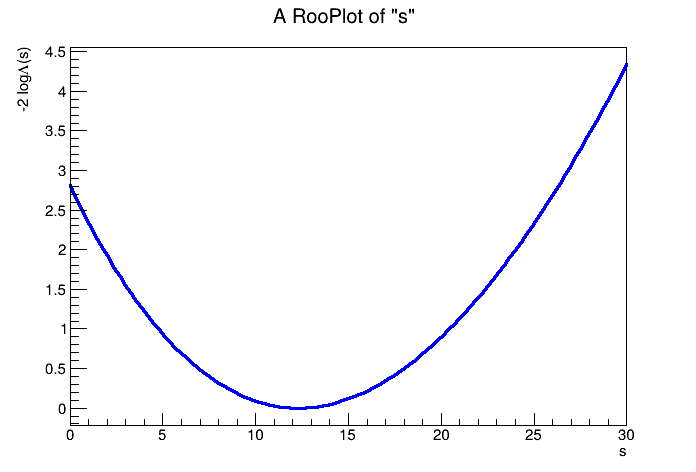

In [44]:
# create profiled log-likelihood
prof = model.createNLL(data).createProfile(ROOT.RooArgSet(ws_onoff.var('s')))
# multiply by 2
minus2LL = ROOT.RooFormulaVar("minus2LL", "2 * @0", ROOT.RooArgList(prof))
frame = ws_onoff.var('s').frame(0, 30)
minus2LL.plotOn(frame)
frame.SetYTitle("-2 log#Lambda(s)")
canvas = ROOT.TCanvas()
frame.Draw()
canvas.Draw()